# Introduction to Decision Trees

-----

In this Notebook, we introduce the [Decision Tree algorithm][wdt], and demonstrate how to effectively use this algorithm for both classification and regression problems. The Decision Tree algorithm is another simple algorithm that can be easy to understand, since a higher level representation of the data is iteratively constructed from the data. Different approaches to building decision trees have been developed, they differ primarily in the ways the higher level representation is constructed. In the end, a decision tree provides a powerful, predictive model that can capture non-linear effects while also being easy to understand and explain. 

In this notebook, we first explore the basic formalism of the decision tree algorithm, including a discussion on several important concepts that can be used to determine how the tree is constructed from a data set. Next, we introduce the use of the decision tree for classification problems by using the Iris data set. In this section we will examine feature importance, the decision surface, visualizing the predictive tree, and the effect of different hyperparameters, before switching to a more complex data set. Finally, we will look at constructing a decision tree for regression, by using a new data set.

-----
[wdt]: https://en.wikipedia.org/wiki/Decision_tree_learning

## Table of Contents

[Formalism](#Formalism)

- [Entropy](#Entropy)
- [Information Gain](#Information-Gain)

[Decision Tree: Classification](#Decision-Tree:-Classification)

- [Classification: Iris Data](#Classification:-Iris-Data)
- [Decision Tree: Decision Surface](#Decision-Tree:-Decision-Surface)
- [Decision Tree: Hyperparameters](#Decision-Tree:-Hyperparameters)
- [Decision Tree: Feature Importance](#Decision-Tree:-Feature-Importance)
- [Decision Tree: Visualizing the Tree](#Decision-Tree:-Visualizing-the-Tree)
- [Classification: Adult Data](#Classification:-Adult-Data)

[Decision Tree: Regression](#Decision-Tree:-Regression)

- [Regression: Auto MPG Data](#Regression:-Auto-MPG-Data)

-----

Before proceeding with the _Formalism_ section of this Notebook, we first have our standard notebook setup code.

-----


In [1]:
# Set up Notebook
%matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings('ignore')

sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Formalism

One of the simplest machine learning algorithms to understand is the [decision tree][wdt]. For a classification task, a decision tree asks a set of questions of the data, and based on the answers determines the final classification. The tree is constructed by recursively splitting a data set into new groupings based on a statistical measure of the data along each different dimension. Popular metrics to determine the dimension on which to split and the value at which to split include entropy, information gain, Gini coefficient, and variance reduction. The terminal nodes in the tree are known as leaf nodes, and provide the final predictions. In the simplest form, the leaf node simply provides the final answer; however, the values in the leaf node can also be combined to form a probabilistic classification or regression estimate.

In addition to their simplicity, decision trees have a number of other benefits. First, they are a _white box model_, which simply means we can understand exactly why a decision tree makes a specific prediction on a given instance. Second, they can handle both numerical and categorical data, and they do not require pre-processing beyond handling missing values. Trees also tend to perform well on large data sets. 

On the other hand, decision trees are prone to overfitting; where they model the training data too well and do not generalize to unseen data. Decision trees can have difficulty classifying on unbalanced classes and they can be unstable to minor changes in the training data. Overall, however, the decision tree is one of a handful of standard machine learning algorithms with which you should be familiar. In future notebooks, we will learn how to overcome many of these disadvantages by employing ensemble learning with decision trees. 

The following figure shows a data set (on the left) and a simple decision tree (on the right). The root node of the decision tree represents the entire data set. When we subdivide the full data into two sub-populations, we create two child nodes, in this case labeled A and B. We can subdivide these sub-populations even further, as demonstrated in the figure where node B is split into two new child nodes: C and D. This process continues until a pre-defined stopping condition is met. Popular choices for this stopping criteria include a maximum tree depth, a minimum number of points in a terminal node, or simply when the node is pure (i.e., all samples in the node have the same category for a classification task).

![Decision Tree Image made by Professor Robert J. Brunner](images/dt-rjb.pdf)
   
The decision on which feature to split, and the actual value along that feature on which to split can be performed in several different manners:
- [Variance reduction][wvr]: the split choice is made to maximally reduce the variance along a feature, useful for regression problems.
- [Gini impurity][wgi]: the split choice is made to minimize misclassifications, especially in a multi-class classification domain.
- [Information gain][wig]: the split choice is selected to create the purest child nodes, based on the concept of entropy and information theory.

Before proceeding with a demonstration of how to construct and use a decision tree classifier, we first explore the concepts of _entropy_ and _information gain_.

-----

[wdt]: https://en.wikipedia.org/wiki/Decision_tree_learning

[wvr]: https://en.wikipedia.org/wiki/Decision_tree_learning#Variance_reduction
[wig]: https://en.wikipedia.org/wiki/Decision_tree_learning#Information_gain
[wgi]: https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity

[[Back to TOC]](#Table-of-Contents)

### Entropy

[Entropy][we] provides a statistical measurement of the information content in a data set. Another viewpoint is that entropy provides a measure of the unexpectedness of a data set, since data that are all the same have low entropy, and thus are easy to predict (or explain). The use of entropy in the context of machine learning follows its use in information theory, as developed by Claude Shannon, who quantified the concept of sharing information electronically. In this context, the entropy provided a means to quantify how much information was contained in a message, or how many bits it would take to communicate the message.

Shannon entropy employs logarithm base 2; logarithms are used since they change multiplications into additions: $\log(ab) = \log(a) + \log(b)$. Formally, the entropy is the negative of the sum of the product of the individual class probabilities and the base 2 logarithm of these same probabilities:

\begin{equation}
h = - \sum_{i = 1}^N P(x_i) \log2(P(x_i))
\end{equation}

To demonstrate how to compute entropy, we will employ a hypothetical two class data set: success (**S**) and failure (**F**), with probabilities $P(S) = p$ and $P(F) = 1 - p$, respectively. In the following Code cell, we compute the entropy, `h`, for this two class example. We first generate a range of probabilities, `p`, between zero and one. Next, we compute the entropy by using the previous formula. Finally we generate a plot of the probability of success versus the calculated entropy. As the figure demonstrates, the entropy is a maximum ($=1$) when the data are equally divided, and is minimal ($\approx 0$) when the data are approximately uniform. Thus, entropy provides a measure of the _purity_ of a data set.

-----

[we]: https://en.wikipedia.org/wiki/Entropy_(information_theory)

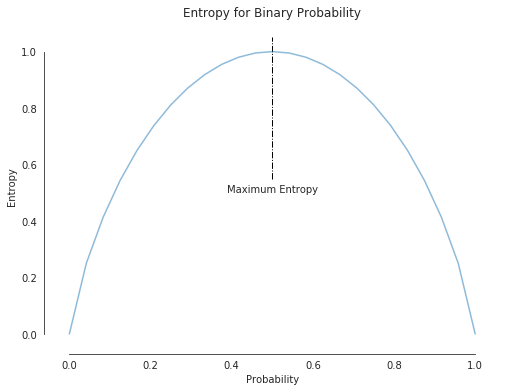

In [2]:
import math

tol = 1E-6

p = np.linspace(tol, 1 - tol, 25)

h = -p * np.log2(p) - (1 - p) * np.log2(1 - p)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(p, h, alpha=0.5)
ax.vlines(0.5, ymin=0.55, ymax=1.05, lw=1, linestyles='-.')
ax.text(0.5, 0.5, 'Maximum Entropy', horizontalalignment='center')

ax.set_title('Entropy for Binary Probability')
ax.set_xlabel('Probability')
ax.set_ylabel('Entropy')
sns.despine(offset=5, trim=True)

-----

We now apply the concept of entropy to a more complex data set. In this case we will use the _tips_ data set to compute the entropy of the categorical features: `day` and `time`, which have four and two options, respectively. To compute entropy we need to determine the probabilities for these different options. To do this, the following Code cell loads the tips data into a DataFrame, and randomly samples the categorical features.

-----

In [3]:
# Load Data Set
tdf = sns.load_dataset('tips')

# Categorical features of interest
cat_features = ['day', 'time']

# Display several random rows
tdf[cat_features].sample(5)

,day,time
139,Thur,Lunch
129,Thur,Lunch
28,Sat,Dinner
185,Sun,Dinner
174,Sun,Dinner


-----

With this DataFrame, we can create dummy features for each categorical option by using the `get_dummies` method. The following Code cell does this and generates a pivot table of the resulting DataFrame to display the aggregate counts of each categorical option. Thus, this approach provides a two by four frequency table, which we can collapse to a single categorical feature (e.g., `day` or `time`) and normalize appropriately to obtain the probabilities required to compute the entropy.

-----

In [4]:
# Compute probabilities as frequency of occurance
cat_data = pd.get_dummies(tdf[cat_features])

# Display pivot table, thataccumulates counts
pd.pivot_table(cat_data, values=['day_Thur', 'day_Fri', 'day_Sat', 'day_Sun'], 
               index=['time_Lunch', 'time_Dinner'], aggfunc=np.sum)

,,day_Fri,day_Sat,day_Sun,day_Thur
time_Lunch,time_Dinner,,,,
0,1,12,87,76,1
1,0,7,0,0,61


-----

The following code cell extracts this new pivot table as a NumPy matrix of shape (2, 4), and sets the print options for NumPy to display numerical data as a maximum of five characters with at most three following the decimal point. The code to accomplish this last part is simply present to make the output of the following Code cells easier to read and is not necessary to follow our presentation on calculating entropy.

-----

In [5]:
# Construct NumPy array for counts
cnts_pt = pd.pivot_table(cat_data, index=['time_Lunch', 'time_Dinner'],
                         aggfunc=np.sum).as_matrix()


# Nice print format for NumPy arrays
float_formatter = lambda x: "%5.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

-----

We can collapse this new matrix (or array) along either axis to obtain the frequency count for each categorical value, and by dividing by the total number of instances, compute the probability for each categorical value in the original data set. The following Code cell computes the counts and probabilities for the `time` feature. Once we have the probability for either `Lunch` or `Dinner`, we compute the entropy of both categorical values, which, for a decision tree, corresponds to the entropy of each child node if we split on this feature. Finally, we sum these individual entropy measures to compute the entropy of this feature over the entire data set. The result is quite large (recall the maximum for a binary option was one), which indicates this would likely be a good feature on which to split.

-----

In [6]:
# Accumulate counts for time
cnts = cnts_pt.sum(axis=1)
print(f'Child node counts = {cnts}')

# Accumulate probabilities for time
probs = cnts / cnts_pt.sum()
print(f'Child node probability = {probs}')

# Compute child node entropy
# Numpy apply function is equivalent to list comprehension
# hc = [-p * np.log2(p) for p in probs]
hc = np.apply_along_axis(lambda p: -p * np.log2(p), 0, probs)
print(f'Child node entropy = {hc}')

# Compute total entropy (sum over children)
ht = sum(hc)
print(f'Node total entropy = {ht: 5.3f}')

Child node counts = [176  68]
Child node probability = [0.721 0.279]
Child node entropy = [0.340 0.514]
Node total entropy =  0.854


-----

<font color='red' size = '5'> Student Exercise </font>

The previous Code cell demonstrated how to compute the entropy for the binary choice `time` feature. Note that we can only split at one value, which would necessitate one or more values being in each child node (for example, Thursday and Friday might be in one child node and Saturday and Sunday might be in the other child node). In the following Code cell, pick one such combination of days, and compute the entropy for the `day` feature. How does this entropy value compare to the entropy calculated for the `time` feature? Try a different combination of days in your two child nodes, how does the entropy change?

-----

-----

[[Back to TOC]](#Table-of-Contents)

### Information Gain

While entropy is a useful measure of the distribution of instances among a set of classes in a data set, its computation and interpretation can become difficult in a feature-rich data set. Instead, we can calculate the relative entropy, or [information gain][wig] for a set of features. In this case, we compute how the selection of one feature and value along which to split affects the probability of the features of interest being split into child nodes.

The computation of the information gain starts with the computation of the individual child node entropies, and the entropy of the parent node for a given feature. Next, we need to determine the weight of each child node's entropy, which is simply the fraction of instances from the parent node that are in each specific child node. The information gain is the entropy of the parent node minus the weighted sum of the entropies of the two child nodes. We demonstrate how to calculate the information gain in the following Code cell, where we use the fact that the probabilities computed from the frequency of occurrences for a two class feature are the weights we need to compute the information gain. 

-----

[wig]: https://en.wikipedia.org/wiki/Kullback–Leibler_divergence

In [7]:
# In this case, weights are just frequency probabilities
wts = probs

# IG = parent entropy - sum over conditional child entropy
ig = ht - np.dot(hc, wts)
print(f'Information gain = {ig: 5.3f}')

Information gain =  0.465


-----

To demonstrate the calculation of information gain for a more complex example, the following Code cell computes the information gain along the `day` feature by splitting the data into two groups: `Fri` and `Sat`, and `Sun` and `Thur`. To perform this computation, we compute the child node counts and probabilities as before, compute the entropy for each of these probabilities, and sum these to get the parent node entropy. Next, we group the four feature value probabilities and entropies into two child nodes, corresponding to our previously mentioned `day` groupings. Finally, we subtract the weighted sum of the child node, relative entropies from the parent node entropy to generate the information gain for this feature and split grouping. In this case, we see that splitting this feature as indicated results in a higher information gain than our previously calculated information gain for splitting on the `time` feature. This indicates that this split would be optimal given these two choices.

-----

In [8]:
# Now compute IG for multi-choice feature

# Accumulate counts for day
cnts = cnts_pt.sum(axis=0)
print(f'Child node counts = {cnts}\n')

# Accumulate probabilities for day
probs = cnts / cnts_pt.sum()
print(f'Child node probability = {probs}\n')

# Compute child node entropy
hc = np.apply_along_axis(lambda p: -p * np.log2(p), 0, probs)
print(f'Child node entropy = {hc}\n')

# Compute total entropy (sum over children)
ht = sum(hc)
print(f'Node total entropy = {ht: 5.3f}\n')

# Conditional entropy, is summed over the relevant children
hnc = np.array([hc[0] + hc[1], hc[2] + hc[3]])

# Weights are joined frequency probabilities
wts = np.array([probs[0] + probs[1], probs[2] + probs[3]])
print(f'Child node conditional entropy = {hnc}\n')

# IG = parent entropy - sum over conditional child entropy
ig = ht - np.dot(hnc, wts)
print(f'Information gain = {ig: 5.3f}')

Child node counts = [19 87 76 62]

Child node probability = [0.078 0.357 0.311 0.254]

Child node entropy = [0.287 0.530 0.524 0.502]

Node total entropy =  1.844

Child node conditional entropy = [0.817 1.026]

Information gain =  0.908


-----

[[Back to TOC]](#Table-of-Contents)

## Decision Tree: Classification

With the discussion on node splitting algorithms completed, we can now begin applying the decision tree algorithm to classification tasks. To do this we will use the `DecisionTreeClassifier` estimator from the scikit-learn `tree` module. This estimator will construct, by default, a tree from a training data set. This estimator accepts a number of hyperparameters, including:

- `criterion` : the method by which to measure the quality of a potential split. By default the Gini impurity is used, although information gain can be specified by passing the string `entropy`.
- `max_depth` : the maximum depth of the tree. By default this is `None`, which means the tree is constructed until either all leaf nodes are pure, or all leaf nodes contain fewer instances than the `min_samples_split` hyperparameter value.
- `min_samples_split` : the minimum number of instances required to split a node into two child nodes, by default this is two.
- `min_samples_leaf`: the minimum number of instances required to make a node terminal (i.e., a leaf node). By default this value is one.
- `max_features`: the number of features to examine when choosing the best split feature and value. By default this is `None`, which means all features will be explored.
- `random_state`: the seed for the random number generator used by this estimator. Setting this value ensures reproducibility.
- `class_weight`: values that can improve classification performance on unbalanced data sets. By default this value is `None`.

To demonstrate using a decision tree with the scikit-learn library, we will first load in the Iris data. With these data, we will construct a simple decision tree to introduce the concept of _feature importance_. Next, we will look at the decision surface for the decision tree as applied to the Iris data. After this, we will explore how to visualize the decision tree constructed by the `DecisionTreeClassifier` estimator, before looking at the effect of changing hyperparameters. Finally, we will switch to a larger data set to learn how to employ a decision tree on more complex data.

----
[skdtc]: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

[[Back to TOC]](#Table-of-Contents)

### Classification:  Iris Data

We can now apply the Decision Tree algorithm to the Iris data to create a classification model. The basic approach is simple, and follows the standard scikit-learn estimator philosophy:

1. Import our estimator, [`DecisionTreeClassifier`][skdtc], from the proper scikit-learn module, `tree`.
2. Create the estimator and specify the appropriate hyperparameters. For a decision tree, we can accept the defaults, or specify values for specific hyperparameters, such as `max_depth`.
3. Fit the model to the training data, note that by using our simple `get_iris_data` helper function we have loaded the Iris data, split the data into training and testing sets, and scale all data by first normalizing the training data. Although this last step is not required for a decision tree.
4. Predict new classes with our trained model (or in the simple demonstration below, generate a performance metric via the `score` method).

These steps are demonstrated in the following code cell, where obtain our data, and show the distribution of instances in a two-dimensional scatter plot, create our estimator, fit the estimator to our training data, and generate a performance score on the testing data. 

-----
[skdtc]: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

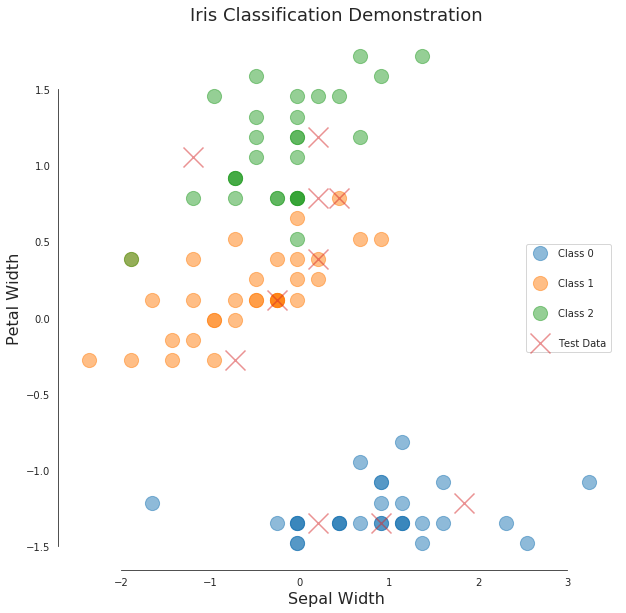

In [9]:
from helper_code import iris as hi

# Amount to hold out for 'blind' testing
test_frac = 0.4

# Show the 'Train' and 'Test' data plot.
show_plot = True

# Split data into training and testing
# Note that we have both 'data' and 'labels'
d_train_sc, d_test_sc, l_train, l_test = \
    hi.get_iris_data(test_frac, show_plot)

In [10]:
# Next lets try Decision Trees
from sklearn.tree import DecisionTreeClassifier

# First we construct our decision tree, we only specify the 
# random_state hyperparameter to ensure reproduceability.
dtc = DecisionTreeClassifier(random_state=23)

# Fit estimator to scaled training data
dtc = dtc.fit(d_train_sc, l_train)

# Compute and display accuracy score
score = 100.0 * dtc.score(d_test_sc, l_test)
print(f"Decision Tree prediction accuracy = {score:5.1f}%")

Decision Tree prediction accuracy =  96.7%


-----

Notice that, even when using only 60% of the total data for training, our decision tree classifier still achieves remarkable accuracy on the testing data. For completeness, we also display the classification report and the confusion matrix in the following two Code cells. The per-class precision and recall are very good, with a minor issue in the prediction of class `Virginica`, which is also demonstrated clearly in the confusion matrix.

-----

In [11]:
from sklearn.metrics import classification_report

# Thre types of Iris in data set
labels = ['Setosa', 'Versicolor', 'Virginica']

# Predict on test data and report scores
y_pred = dtc.predict(d_test_sc)
print(classification_report(l_test, y_pred, \
                            target_names = labels))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        21
  Versicolor       0.90      1.00      0.95        18
   Virginica       1.00      0.90      0.95        21

   micro avg       0.97      0.97      0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



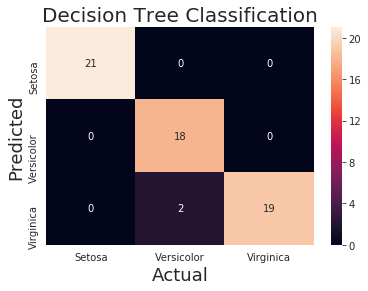

In [12]:
from helper_code import mlplots as ml

# Call confusion matrix plotting routine
ml.confusion(l_test.reshape(l_test.shape[0]), 
             y_pred, labels, 3, 
             'Decision Tree Classification')

-----

[[Back to TOC]](#Table-of-Contents)

### Decision Tree:  Feature Importance

As the previous example demonstrated, the decision tree can often provide impressive performance rather easily. We can, however, leverage the fact that the decision tree is constructed by repeatedly determining the most important feature on which to split the data to compute the relative importance of each feature in the training data set. In effect, this is computed by determining to what percentage each feature was used to split the training data, formally this is known as the _Gini importance_. As a result, higher values indicate a more important feature. 

We demonstrate how to extract the feature importance for a decision tree classifier in the following Code cell, where we see that for this training data set, only two features: Petal Width and Petal Length account for most of the importance.

----

In [13]:
# Display feature importance as computed from the decision tree

# Feature names
feature_names = ['Sepal Length', 'Sepal Width', 
                 'Petal Length', 'Petal Width']

# Display name and importance
for name, val in zip(feature_names, dtc.feature_importances_):
    print(f'{name} importance = {100.0*val:5.2f}%')

Sepal Length importance =  1.67%
Sepal Width importance =  2.22%
Petal Length importance =  5.59%
Petal Width importance = 90.51%


-----

[[Back to TOC]](#Table-of-Contents)

### Decision Tree:  Decision Surface

To better understand how a classification algorithm performs on a given data set and compare multiple classifiers, we can train a classifier and use this estimator to predict values on a grid of values. In this case, we can see how the algorithm would classify data that spans a particular combination of feature values. This visualization, in two dimensions, is known as a decision surface since we are seeing how decisions would be made. 

We demonstrate constructing a decision surface in the following Code cell by using several helper methods. First, we need to reduce our data set down to two dimensions to make the decision surface visualization. This step is accomplished by the `trim_data` helper function, which takes our training features and labels and returns a two-dimensional array that holds two features: Sepal Width and Petal Width, along with the classification. Next, we generate a two-dimensional mesh grid along these two dimensions. 

We fit a decision tree to the trimmed two-dimensional data (we could fit on the full data, but in this example we use only the two dimensions used in the plot), and apply to the mesh grid to construct the decision surface. Finally, we generate a scatter plot of the training data and color the underlying mesh appropriately by the predicted class for that cell.

As the decision surface below demonstrates, this default decision tree separates the classes cleanly with linear cuts. On the other hand, even though each split generates a linear classification, their combination can be non-linear (note the rectangle cut-out enclosing the single instance of _versicolor_).

-----

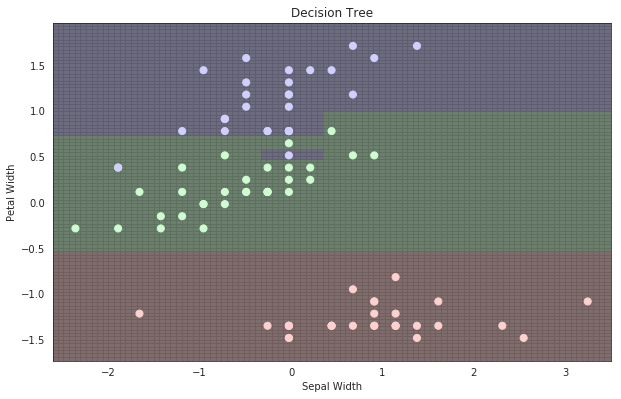

In [14]:
# Make a two-dimensional Iris data set
n_data = hi.trim_data(d_train_sc, l_train)

# Construct mesh grid data
mdata = hi.get_mdata(n_data)

fig, ax = plt.subplots(figsize=(10,8))

# Now train our model
dtc.fit(n_data[:,:2], n_data[:,2])
    
# Predict for mesh grid
z = dtc.predict(mdata)
    
# Plot training data and mesh grid
hi.splot_data(ax, n_data, mdata, z,
              'Sepal Width', 'Petal Width', 50)
    
ax.set_title(f'Decision Tree') ;

-----

[[Back to TOC]](#Table-of-Contents)

### Decision Tree:  Visualizing the Tree

A decision tree is one of the easiest algorithms to understand since a decision tree essentially asks a list of questions to partition the data. The scikit learn library includes an [`export_graphviz`][sket] method that actually generates a visual tree representation of a constructed decision tree classifier. This representation is in the [`dot`][dot] format recognized by the standard, open source [`graphviz`][gv] library. 

In the next few Code cells, we export a _dot_ format of the Iris decision tree we just constructed, convert it to an SVG image, and subsequently display this image inline in our notebook. Note, if the _graphviz_ module was available, we could generate and display the decision tree directly in our notebook as demonstrated in the comments of the third Code cell below.

-----
[sket]: http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html#sklearn.tree.export_graphviz
[dot]: http://www.graphviz.org/doc/info/lang.html
[gv]:http://www.graphviz.org

In [15]:
# First we construct our a shallow decision tree, this is
# simply a demonstration used to show feature improtance
# and how to view a tree, hence we need a shallow tree
dtc = DecisionTreeClassifier(max_depth=3, random_state=23)

dtc = dtc.fit(d_train_sc, l_train)

-----

Note, this decision tree classifier is different than our original decision tree classifier since we set the `max_depth` hyperparameter to three. We display the feature importance for this new tree to compare to our original feature importance. In this case, we see that the two features we identified before are exclusively used to construct the new tree. Thus, we can infer that the original tree first used these two features to split the training data, before using the other two features to make leaf nodes.

-----

In [16]:
# Display feature importance as computed from the decision tree

# Feature names
feature_names = ['Sepal Length', 'Sepal Width', 
                 'Petal Length', 'Petal Width']

# Display name and importance
for name, val in zip(feature_names, dtc.feature_importances_):
    print(f'{name} importance = {100.0*val:5.2f}%')

Sepal Length importance =  0.00%
Sepal Width importance =  0.00%
Petal Length importance =  4.82%
Petal Width importance = 95.18%


In [17]:
# Note the version of scikit learn we can use in this class
# currently limits our ability to control the appearance
# of the tree. If we have graphivz installed, one can simply 
# perform the following steps to create and visualize a tree
# in a Jupyter notebook:
#
# import graphviz 
# tree_data = export_graphviz(dtc, out_file=None) 
# my_tree = graphviz.Source(tree_data) 
# my_tree 

from sklearn.tree import export_graphviz

# Write the dot representation of the tree to a file
with open('tree.dot', 'w') as fdot:
    export_graphviz(dtc, fdot, feature_names=feature_names)

In [18]:
# We run the dot tool at the command line to create a viewable image.
!dot -Tsvg tree.dot -o tree.svg

-----

We now display the generated tree visualization, and see that, as expected, the Petal Width feature is used for the primary splits, indicating it is more important, while the Petal length feature is used to split into leaf nodes. While we did not discuss it in this section, there are various options that can be passed to the [`export_graphviz`][skeg] function to decorate the resulting tree visualization. The online documentation for this method provides more information.

-----

[skeg]: http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

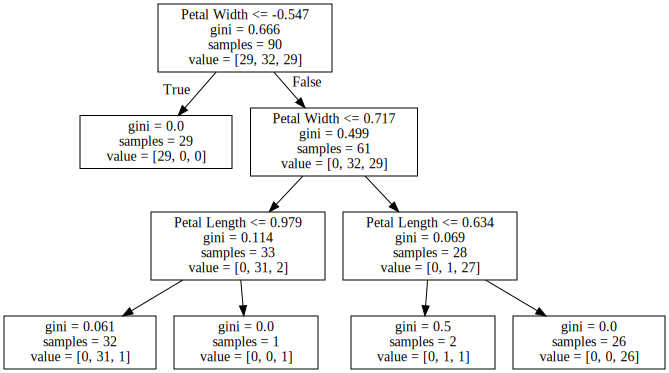

In [19]:
# Now display the image inline
from IPython.display import SVG
SVG(filename='tree.svg')

-----

[[Back to TOC]](#Table-of-Contents)

### Decision Tree: Hyperparameters

A partial list of the hyperparameters that are available to use with the [DecisionTreeClassifier][skdtc] were presented, the full set is available from the estimator's online documentation. Of these hyperparameters, the effects of some are easier to understand, such as the `max_depth`, which limits how many split levels can be used to build a tree. To fully understand the impact of a hyperparameter, beyond simply computing the performance metrics for different values, we can construct and compare decision surfaces for different values of a particular hyperparameter.

In the following Code call, we generate three different decision surfaces, corresponding to three different values of the `max_depth` hyperparameter: 3, 6, and 9. As the following figures demonstrate, the first decision surface is rather simple, two linear cuts. The second decision surface is more complex, with a break in one of the original splits (along the Sepal Width feature). Finally, the final figure more closely resembles the decision surface for our original decision tree classifier. Note that in this case the decision tree is only splitting on these two features. 

----

[skdtc]: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

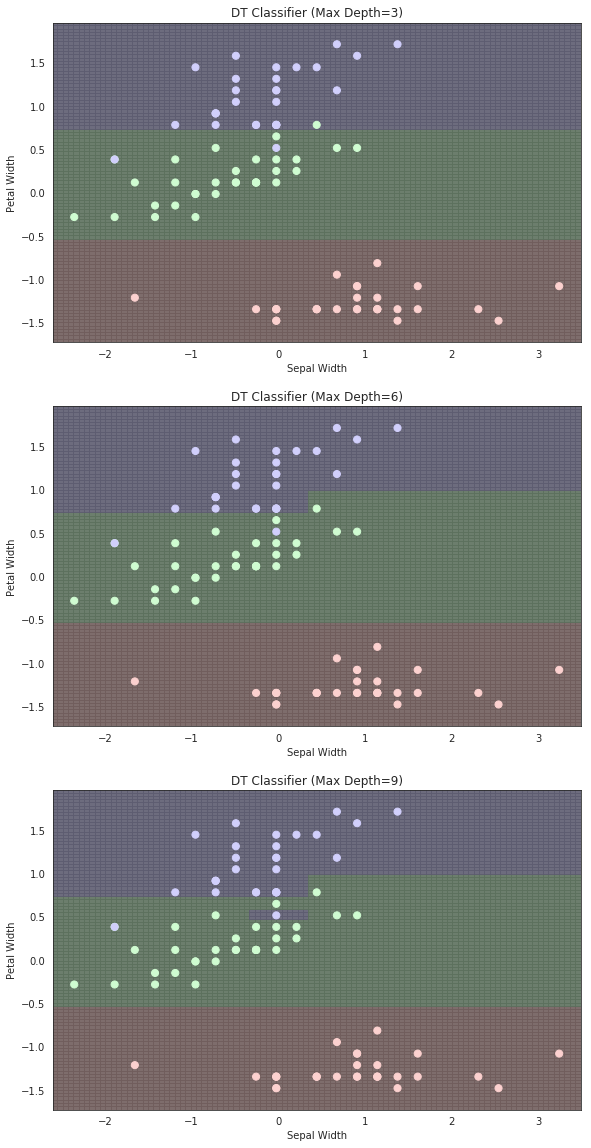

In [20]:
# Show the mesh grid and training data

fig, axs = plt.subplots(figsize=(10,20), nrows=3, ncols=1, 
                        sharex=False)

# Iterate through different neighbor counts
for idx, depth in enumerate([3, 6, 9]):
    
    # Now train our model
    dtc.set_params(max_depth=depth, random_state=23)
    
    # Now train our model
    dtc.fit(n_data[:,:2], n_data[:,2])
    
    # Predict for mesh grid
    z = dtc.predict(mdata)
    
    # Plot training data and mesh grid
    hi.splot_data(axs[idx], n_data, mdata, z, 
                  'Sepal Width', 'Petal Width', 50)
    
    axs[idx].set_title(f'DT Classifier (Max Depth={depth})')

-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cell, we generated decision surfaces for three different values of the `max_depth` hyperparameter. In the previous Code cell, try making the following changes and think about what you can learn from the new decision surfaces. 

1. Change the values of `max_depth` to 4, 8, and 12.
3. Try using a different hyperparameter, such as changing the `criterion` to indicate information gain should be used to make the splits.

-----

-----

[[Back to TOC]](#Table-of-Contents)

## Classification: Adult Data

We now turn to a more complex data set with which to perform classification by using a decision tree. The data we will explore next is the [Adult income prediction task][uciad]. These data were extracted by Barry Becker from the 1994 Census database and consist of the following features: age, workclass, fnlwgt, education, education-num, marital-status, occupation, relationship, race, sex, capital-gain, capital-loss, hours-per-week, native-country, and salary. Of these, only five are continuous:  fnlwgt, education-num, capital-gain, capital-loss, and hours-per-week, the others are discrete. The last column, salary, is discrete and contains one of two strings to indicate if the salary was below or above $50,000. This is the column we will use to make our label.

In the following two Code cells, we first build a full path and file name for where this data will be stored locally. Next, we check to see if the data is already available locally, and if not, we use the `wget` command to pull the data from the UCI machine learning repository for local analysis. Note that we could simply pull the data from the UCI repository directly by specifying the URL (or web address) for the data in the pandas DataFrame `csvreader` method. However, doing so would be problematic in a course setting where many students might be repeatedly downloading the same data set. 

Note that these two code cells will be used repeatedly in future notebooks, which will allow these data to be downloaded once and reused many times in this course. We will also use similar code cells to download other data, from this repository or other sites.

-----
[uciad]: https://archive.ics.uci.edu/ml/datasets/Adult

In [21]:
# Adult data file from UCI ML Repository
# http://archive.ics.uci.edu/ml/machine-learning-databases/adult/

# First we find our HOME directory
tmp = !echo $HOME

# We construct the full path, below our 
# HOME directory to file location
data_file=tmp[0] + '/data/adult.data'

In [22]:
%%bash -s "$data_file"

# Note, we passed in a Python variable above to the Bash script 
# which is then accessed via positional parameter, or $1 in this case.

# First test if file of interest does not exist
if [ ! -f "$1" ] ; then

# If it does not exist, we grab the file from the Internet and
# store it locally in the data directory

wget -O "$1" http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

else
    
    echo "File already exists locally."
fi

File already exists locally.


-----

Now that the _adult data_ has been stored locally, we can read the data into a DataFrame and begin pre-processing it to enable the application of a decision tree for classification. To do this, we first use the pandas `read_csv` function to read the local file. We explicitly define the column names, and indicate that the columns are delimited by white space. Once the DataFrame is created, we randomly sample five rows to verify that the data has been successfully read.

-----

In [23]:
# Adult data archived at UCI ML Repository

col_names = ['Age', 'Workclass', 'FNLWGT', 'Education', 
             'EducationLevel', 'MaritalStatus', 'Occupation', 
             'Relationship', 'Race', 'Sex', 'CapitalGain', 'CapitalLoss', 
             'HoursPerWeek', 'NativeCountry', 'Salary']

# Read CSV data from URL return Pandas
adult_data = pd.read_csv(data_file, index_col=False, names = col_names)

# Display random sample
adult_data.sample(5)

,Age,Workclass,FNLWGT,Education,EducationLevel,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Salary
26627,30,Self-emp-inc,127651,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1887,48,United-States,>50K
28195,28,Private,226891,Some-college,10,Never-married,Adm-clerical,Unmarried,Asian-Pac-Islander,Female,0,0,30,?,<=50K
21769,31,Private,36069,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,35,United-States,<=50K
5036,27,Private,194590,Assoc-acdm,12,Married-civ-spouse,Adm-clerical,Wife,Black,Female,0,0,25,United-States,<=50K
6352,44,Federal-gov,280362,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K


-----

The data sample displayed by the previous Code cell does not indicate any problems with the data that must be fixed, but to ensure the data are clean, we first compute and display summary statistics by using the `describe` function on our DataFrame.

-----

In [24]:
# Display descriptive statistics
adult_data.describe()

,Age,FNLWGT,EducationLevel,CapitalGain,CapitalLoss,HoursPerWeek
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


-----

The descriptive statistics indicate that the numerical columns all contain valid data, and that the ranges are reasonable. At this point, in a real world problem we would also explore the categorical features, for example, checking that there are no missing entries. In this case, however, we can proceed to the next step, where we define our label feature. This data is generally used to test classification algorithms, as the data include a _Salary_ column that includes one of two entries: `<=50K` or `>50K` to indicate if the individual's salary is less than or equal to \\$50,000 or if the individual's salary exceeds \\$50,000. 

To apply a machine learning algorithm to these data, we need to generate a numerical label that maps to these two values. For this, we create a new column in our DataFrame called `Label` and map the original column to $1$ if the `Salary` feature is equal to `>50K` and $0$ otherwise. This step is done in the following Code cell, where we map a lambda function onto the `Salary` feature to create this new feature. The second Code cell compares the original `Salary` feature to our new `Label` feature by randomly sampling twelve instances to ensure this task was completed successfully. Finally, the third Code cell drops the original `Salary` feature since it is no longer required. In practice, this step is not necessary, but we do it here to reduce the size of the overall data set used in this notebook.

-----

In [25]:
# Create label column, one for >50K, zero otherwise.
adult_data['Label'] = adult_data['Salary'].map(lambda x : 1 if '>50K' in x else 0)

In [26]:
# Display label and original column for comparison
adult_data[['Salary', 'Label']].sample(12)

,Salary,Label
5751,<=50K,0
19197,<=50K,0
8456,<=50K,0
23884,<=50K,0
4735,<=50K,0
25275,>50K,1
9420,<=50K,0
1119,<=50K,0
19277,<=50K,0
16824,<=50K,0


In [27]:
# Now we can drop the original column
adult_data = adult_data.drop('Salary', axis=1)

-----

With our new `Label` feature, we can compute what is known as the _zero model_, in which we classify the data by always predicting the majority class. While we do not do this in practice since the model provides no predictive power or insights into the data, this does set a useful baseline for how well an algorithm should perform. Any model that performs worse or similar to the _zero model_ should be discarded. Instead, we will want to perform better than this value. In this case, our zero model performs at a 75% classification accuracy, which indicates that our data set is unbalanced since we have roughly three lower salary instances to every higher salary instance.

-----

In [28]:
labels = adult_data['Label']
print(f'{np.sum(labels==0):d} low salaries')
print(f'{np.sum(labels==1):d} high salaries')

zm = float(np.sum(labels==0)) / (np.sum(labels==0) + np.sum(labels==1))

print(f'Zero Model Performance = {100.0 * zm:4.2f}%')

24720 low salaries
7841 high salaries
Zero Model Performance = 75.92%


-----

With our target label constructed, we now create the feature array that we will use to construct the decision tree classifier. To do this, we will first extract and convert the categorical features to binarized features, and then extract the numerical features. Finally, we will combine these two data sets together to make the final feature array.

In the following Code cell, we create a Python list containing the categorical features, we use this list to select the categorical features (note this would be equivalent to calling `adult_data[['Education']]` for every categorical feature). We use the `get_dummies` function to create binarized features for each of these categorical features. Once created, we randomly sample five rows from this categorical DataFrame. In the end, we have 95 new categorical features.

-----

In [29]:
categorical = ['Education', 'Workclass', 'Race', 'Sex', 'Occupation', 'Relationship', 'NativeCountry']

cat_data = pd.get_dummies(adult_data[categorical])
cat_data.sample(5)

,Education_ 10th,Education_ 11th,Education_ 12th,Education_ 1st-4th,Education_ 5th-6th,Education_ 7th-8th,Education_ 9th,Education_ Assoc-acdm,Education_ Assoc-voc,Education_ Bachelors,...,NativeCountry_ Portugal,NativeCountry_ Puerto-Rico,NativeCountry_ Scotland,NativeCountry_ South,NativeCountry_ Taiwan,NativeCountry_ Thailand,NativeCountry_ Trinadad&Tobago,NativeCountry_ United-States,NativeCountry_ Vietnam,NativeCountry_ Yugoslavia
29143,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
25877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6230,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10441,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


-----

Next, we construct our numerical feature DataFrame, which is easier since we only need to pull the relevant columns from the original DataFrame. Once this is done, we randomly sample five rows to visualize the results.

-----

In [30]:
numerical = ['Age', 'EducationLevel', 'HoursPerWeek', 'CapitalGain', 'CapitalLoss']

num_data = adult_data[numerical]
num_data.sample(5)

,Age,EducationLevel,HoursPerWeek,CapitalGain,CapitalLoss
17961,37,9,30,0,0
28174,34,9,48,0,0
20215,52,10,45,0,0
8744,22,9,50,0,0
25065,37,11,48,0,0


-----

We now combine these two DataFrames into a new `feature` DataFrame that we will use to perform decision tree classification. As one last check, we randomly sample five instances from this `feature` DataFrame. Note our data set is wide, with 100 columns.

-----

In [31]:
features = pd.concat([num_data, cat_data], axis=1)
features.sample(5)

,Age,EducationLevel,HoursPerWeek,CapitalGain,CapitalLoss,Education_ 10th,Education_ 11th,Education_ 12th,Education_ 1st-4th,Education_ 5th-6th,...,NativeCountry_ Portugal,NativeCountry_ Puerto-Rico,NativeCountry_ Scotland,NativeCountry_ South,NativeCountry_ Taiwan,NativeCountry_ Thailand,NativeCountry_ Trinadad&Tobago,NativeCountry_ United-States,NativeCountry_ Vietnam,NativeCountry_ Yugoslavia
26811,48,15,25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
13107,67,14,72,15831,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2291,46,9,37,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10493,48,14,50,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9829,50,10,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


-----

With our feature and label data prepared, we are now ready to begin the machine learning process. In the following two Code cells we first create our decision tree classifier, and then measure its performance on our training data. In the first Code cell, we start by splitting our data into training and testing samples. Since we have over 30,000 instances in our data set, our standard 60%:40% split should be sufficient. Next, we create the `DecisionTreeClassifier` estimator. The only hyperparameter that we specify at this time is  `random_state` in order to ensure reproducibility. Next, we fit this estimator to our training data, and generate an accuracy score on our test data. 

In the second Code cell, we compute and display a simple accuracy score before generating and displaying the full classification report. Note that even with this simple approach, our decision tree classifier performs well, easily beating the zero model demonstrated earlier. In addition, the report indicates that our model performs worst in predicting the positive class. Specifically, the recall indicates that we incorrectly label positive targets as negative. This means that our classifier incorrectly labels individuals who do earn a high salary as being in the low salary category. This could prove problematic, for example, if we are seeking to target high wage earners in a marketing campaign.


----

In [32]:
from sklearn.model_selection import train_test_split

frac = 0.4
d_train, d_test, l_train, l_test = \
    train_test_split(features, labels,
                     test_size=frac, random_state=23)

adult_model = DecisionTreeClassifier(random_state=23)

adult_model = adult_model.fit(d_train, l_train)

In [33]:
from sklearn import metrics

# Classify test data and display score and report
predicted = adult_model.predict(d_test)
score = 100.0 * metrics.accuracy_score(l_test, predicted)
print(f'Decision Tree Classification [Adult Data] Score = {score:4.1f}%\n')
print('Classification Report:\n {0}\n'.format(
    metrics.classification_report(l_test, predicted)))

Decision Tree Classification [Adult Data] Score = 82.0%

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      9811
           1       0.64      0.61      0.63      3214

   micro avg       0.82      0.82      0.82     13025
   macro avg       0.76      0.75      0.75     13025
weighted avg       0.82      0.82      0.82     13025




-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cells, we constructed a decision tree for classification and applied it to the adult income prediction task. The initial result was reasonable, but try making the following changes to see if you can do better.

1. Change the features used in the classification, for example drop one or more columns such as native country. Do the results change? 
3. Try using different hyperparameter values, such as specifying to use information gain at tree splits (via the `criterion` hyperparameter) or try using a random `splitter`.
4. Try setting the `class_weight` hyperparameter to `balanced` to aid in dealing with the unbalanced training data.

-----

[[Back to TOC]](#Table-of-Contents)

## Decision Tree: Regression

A decision tree can also be used to perform regression, however, in this case the goal is to create leaf nodes that contain data that are nearby in the overall feature space. To predict a continuous value from a decision tree, we either have leaf nodes with only one feature, and use the relevant feature from that instance as our predictor, or we compute summary statistics from the instances in the appropriate leaf node, such as the mean or mode.

To perform regression with the scikit-learn library we employ the [`DecisionTreeRegressor`][skdtr] estimator in the tree module. This estimator employs the same set of hyperparameters as the `DecisionTreeClassifier` estimator, and is, therefore, used in a similar manner. One other point, which is also true for classification, by specifying the `random_state` hyperparameter, we ensure reproducibility. This is because every time a tree is constructed, the features are always randomly  permuted at every split. Thus, even if we use the same set of hyperparameters and the same set of training data, we can end up with different trees if the `random_state` hyperparameter is not fixed.

In this section we employ decision trees to perform regression on a new data set, the automotive fuel performance prediction. First, we will introduce these data, and prepare them for the regression task. We will employ the patsy module to use a regression formula to create our dependent and independent feature matrices. Finally, we will construct a decision tree regressor on these data and evaluate its performance.


-----

[skdtr]: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

[[Back to TOC]](#Table-of-Contents)

### Regression: Auto MPG Data

The [automobile fuel performance prediction data][uciap] were collated by Ross Quinlan and released in 1993. The data contains nine features: mpg, cylinders, displacement, horsepower, weight, acceleration, model year, origin, and car name. Of these, the first is generally treated as the dependent variable (i.e., we wish to predict the fuel efficiency of the cars), while the next seven features are generally used as the independent variables. The last feature is a string that is unlikely to be useful when predicting on new, unseen data, and is, therefore, not included in our analysis.

Of these features, three are discrete: cylinders, year, and origin, and four are continuous: 
displacement, horsepower, weight, and acceleration. In the first two Code cells, we first construct the local path and file name for this data before checking to see if this data file exists locally. If not, we use the `wget` command to pull the data from the UCI ML repository.

----
[uciap]: https://archive.ics.uci.edu/ml/datasets/auto+mpg

In [34]:
# Auto MPG data file from UCI ML Repository
# https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/

# Second we construct the full path, below our 
# HOME directory to file location
data_file=tmp[0] + '/data/auto-mpg.data'

In [35]:
%%bash -s "$data_file"

# Note, we passed in a Python variable above to the Bash script 
# which is then accessed via positional parameter, or $1 in this case.

# First test if file of interest does not exist
if [ ! -f "$1" ] ; then

# If it does not exist, we grab the file from the Internet and
# store it locally in the data directory

wget -O "$1" https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data

else
    
    echo "File already exists locally."
fi

File already exists locally.


-----

Now that the data are stored locally, we can read them into a DataFrame by using our provided column names and by indicating that the features are delimited by whitespace. The following Code cell performs this task, before randomly sampling five rows to demonstrate that this process completed successfully.

-----

In [36]:
# Names for our columns
col_names = ['MPG', 'Cylinders', 'Displacement',
             'Horsepower', 'Weight', 'Acceleration', 
             'Year', 'Origin', 'Name']

# Create DataFrame and sample the result
auto_data = pd.read_csv(data_file, index_col=False, names = col_names, 
                  delim_whitespace=True)
auto_data.sample(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Year,Origin,Name
80,22.0,4,122.0,86.00,2395.0,16.0,72,1,ford pinto (sw)
334,23.7,3,70.0,100.0,2420.0,12.5,80,3,mazda rx-7 gs
220,33.5,4,85.0,70.00,1945.0,16.8,77,3,datsun f-10 hatchback
257,19.4,6,232.0,90.00,3210.0,17.2,78,1,amc concord
150,26.0,4,108.0,93.00,2391.0,15.5,74,3,subaru


-----

While it may not be obvious from the previous random sample from the _auto data_, the `Horsepower` feature has several unknown values that are indicated by a `?` in the field of that value. If we continue to use that feature, patsy will treat the values as strings rather than numbers and build extra dummy variables for each value. Since this is not what we would desire, we instead ignore this feature in the analysis in this notebook. An alternative technique would be to convert the `?` into a missing value, and either drop rows with missing values, or impute the missing value. This later approach will be explored in the introduction to Gaussian Process notebook.

Given this DataFrame, we can now regress on our independent variables to build a predictive model for our dependent variable. First, we use the [patsy module][pm] to create our independent and dependent variable matrices from the input DataFrame. Note that we wrap categorical (or discrete) features in `C(...)`. This informs patsy that the named feature is categorical. Patsy supports a rich formula interface, the online documentation provides complete details. As before, the `dmatrices` function will, in this case, return a DataFrame for both the dependent variable, `y`, and the independent variables, `x`.

-----
[pm]: http://patsy.readthedocs.io/en/latest/

In [37]:
import patsy as pts 

y, x = pts.dmatrices('MPG ~ C(Cylinders) + Displacement + ' +
                     'Weight + Acceleration + C(Year) + C(Origin)', 
                     data=auto_data, return_type='dataframe')

x.sample(5)

,Intercept,C(Cylinders)[T.4],C(Cylinders)[T.5],C(Cylinders)[T.6],C(Cylinders)[T.8],C(Year)[T.71],C(Year)[T.72],C(Year)[T.73],C(Year)[T.74],C(Year)[T.75],...,C(Year)[T.78],C(Year)[T.79],C(Year)[T.80],C(Year)[T.81],C(Year)[T.82],C(Origin)[T.2],C(Origin)[T.3],Displacement,Weight,Acceleration
288,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,318.0,3830.0,15.2
34,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,225.0,3439.0,15.5
276,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,121.0,2795.0,15.7
342,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,135.0,2385.0,12.9
248,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,91.0,1800.0,16.4


-----

With these two DataFrames, we can now build a regressive model. First, we import the `DecisionTreeRegressor` before splitting our independent and dependent variables into training and testing samples. Next, we create our estimator, specifying a value for our `random_state` hyperparameter to enable reproducibility. Finally, we fit the model and display a predictive score. The second code cell computes a number of different regression performance metrics and displays the results. Notice that, unlike the case for classification, regression performance metrics are generally better when they are smaller. This is because these metrics are often quantifying the difference between the test and predicted features, which we want to minimize.

-----

In [38]:
from sklearn.tree import DecisionTreeRegressor

# Split data intro training:testing data set
ind_train, ind_test, dep_train, dep_test = \
    train_test_split(x, y, test_size=frac, random_state=23)

# Create Regressor with default properties
auto_model = DecisionTreeRegressor(random_state=23)

# Fit estimator and display score
auto_model = auto_model.fit(ind_train, dep_train)
print('Score = {:.1%}'.format(auto_model.score(ind_test, dep_test)))

Score = 53.3%


In [39]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

# Regress on test data
pred = auto_model.predict(ind_test)

# Copute performance metrics
mae = mean_absolute_error(dep_test, pred)
mse = mean_squared_error(dep_test, pred)
mbe = median_absolute_error(dep_test, pred)
mr2 = r2_score(dep_test, pred)

ev_score = explained_variance_score(dep_test, pred)

# Display metrics
print(f'Mean Absolute Error   = {mae:4.2f}')
print(f'Mean Squared Error    = {mse:4.2f}')
print(f'Median Absolute Error = {mbe:4.2f}')
print(f'R^2 Score             = {mr2:5.3f}')
print(f'Explained Variance    = {ev_score:5.3f}')

Mean Absolute Error   = 3.37
Mean Squared Error    = 25.14
Median Absolute Error = 2.00
R^2 Score             = 0.533
Explained Variance    = 0.544


-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cells, we constructed a decision tree for regression and applied it to the automobile fuel performance prediction task. The initial result was reasonable, but try making the following changes to see if you can do better.

1. Change the features used in the regression, for example drop one column, such as `origin`. Do the results change? 
3. Try using different hyperparameter values, such as specifying a different metric to reduce the variance at tree splits (via the `criterion` hyperparameter), or try using a random `splitter`.

-----


## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. A detailed [blog article][1] on decision trees and computing split features
1. A presentation style web article on [building decision trees][2] with scikit learn
2. An article on [building decision trees][3] from scratch in Python at Analytics Vidhya
12. A readable article on [building and using][4] decision trees in Python

-----
[1]: https://web.archive.org/web/20170628054712/http://decisiontrees.net/decision-trees-tutorial/tutorial-4-id3/

[2]: http://www.ritchieng.com/machine-learning-decision-trees/

[3]: https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/

[4]: https://dataaspirant.com/2017/02/01/decision-tree-algorithm-python-with-scikit-learn/

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode 